# Supplementary analysis script for 'Cohesin and condensin extrude DNA loops in a cell-cycle dependent manner'

### Golfier et al. , March 2020


This script is a supplementary material to the article 'Cohesin and condensin extrude DNA loops in a cell-cycle dependent manner' by Golfier et al. , eLife 2020. To execute this script, please download the supplementary data file as indicated in the article. <br>
The supplementary data file contains '*_output' files in python data format, that resulted from the segmentation of loop extrusion events on individual DNA molecules. All analysis was done in python. This script reads in the looping data from these files and performs the following tasks in individual blocs: 

#### 1. Plot of the dynamics of loop extrusion 
#### 2. Analysis of relative DNA extension and the tension on the DNA molecule
#### 3. Symmetry score of each looping event
#### 4. Determining the initial extrusion rate from the fit to the loop data
#### 5. Analysis of loop movement 


In [2]:
# import relavent packages

import time
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import signal
from PIL import Image
import pickle
import csv

from PIL import Image
from PIL.TiffTags import TAGS

import glob

import pickle
import pandas as pd

## 0. General data structure

All '*_output' data files are contain the following entries: 

0 - summed intensity in region I for each time point <br>
1 - summed intensity in region II for each time point <br>
2 - summed intensity in the loop for each time point <br>
3 - initial relative extension of the DNA molecule in kb (dye-corrected) <br>
4 - initial relative extension of the DNA molecule in um (dye-corrected) <br>
5 - relative position of the maximum intensity for each time point <br>
6 - start frame number of loop extrusion in original microscopy data <br>
7 - end frame number of loop extrusion in original microscopy data <br>
8 - time step between two subsequent frames <br>
9 - pixel size in um <br>
10 - dye corrected contour length of the DNA molecule <br>
11 - symmetry score for the looping event <br>



In [3]:
# define path that contains the python data-files from the loop analysis from all strands
path = '/Users/golfier/Desktop/ReviewerResponse/data/inter'

# define output path to save ensuing data-files and plots
out = '/Users/golfier/Desktop/ReviewerResponse'


# find all output files in folder
paths_tiff = glob.glob(os.path.join(path,'*_output'))

len(paths_tiff), paths_tiff

(10,
 ['/Users/golfier/Desktop/ReviewerResponse/data/inter/inter10_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter1_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter2_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter3_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter4_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter5_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter6_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter7_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter8_output',
  '/Users/golfier/Desktop/ReviewerResponse/data/inter/inter9_output'])

## 1. Loop extrusion dynamics and DNA tension

First lets estimate the stall force of loop extrusion (or any other DNA-compacting event) by quantifying the level of DNA extension and converting it to an absolute tension on the strand using the worm-like chain (WLC) model (Marko 1995). 

The idea is that during loop extrusion the slack in the system is redistributed into the loop region which tenses the DNA residing outside of the loop. As the distance between the endpoints of the DNA (l_biobio in kb) is constant, tension builds up on the DNA strand as the loop grows and DNA gets more and more stretched. The ratio of end-to-end distance (l_biobio) over the remaining slack in the system (contour length - loop size) for each time-point gives a dimensionless measure 'relative extension' of the DNA molecule. The relative extension of DNA can be related to a force using the known force-extension relationship of the (WLC) model (Marko 1995): 

# $\frac{F P}{k_{B} T} = \frac{1}{4} (1-\frac{x}{L_{0}})^{-2} -\frac{1}{4} + \frac{x}{L_{0}}$

P - persistence length of DNA = 51 +- 2nm (from Bouchiat et al. 1998) <br>
L0 - contour length (0.34 nm per bp for B-form DNA)


The first bloc is based on the looping quantification which returns a python data file ('filename_output'), containing the absolute size (in kb) of each region for every time-step and the dye-corrected end-to-end distance (l_biobio in kb). 

inter10_output
End-to-end distance: 10.03 kb
Final loop size: 33.74 kb
stall force:  0.23 pN


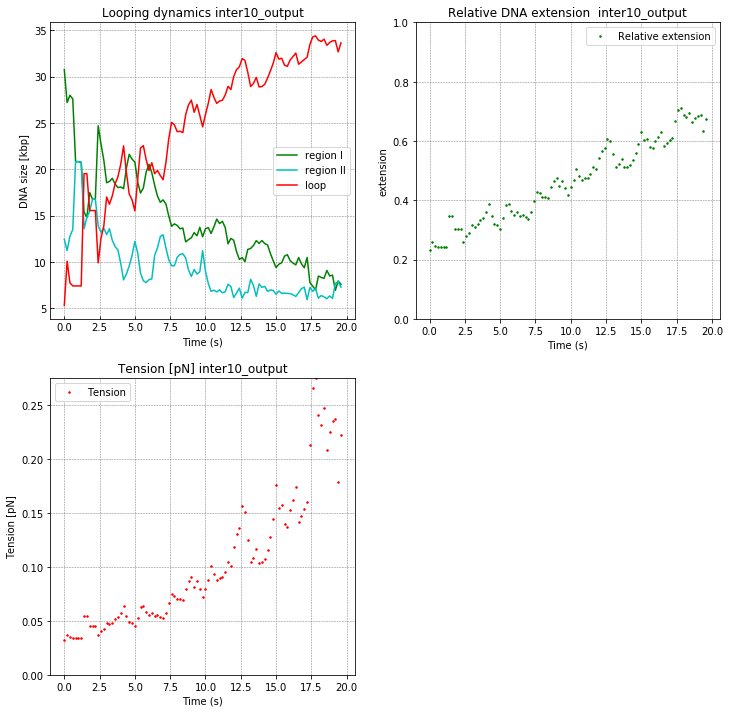

inter1_output
End-to-end distance: 14.47 kb
Final loop size: 24.31 kb
stall force:  0.16 pN


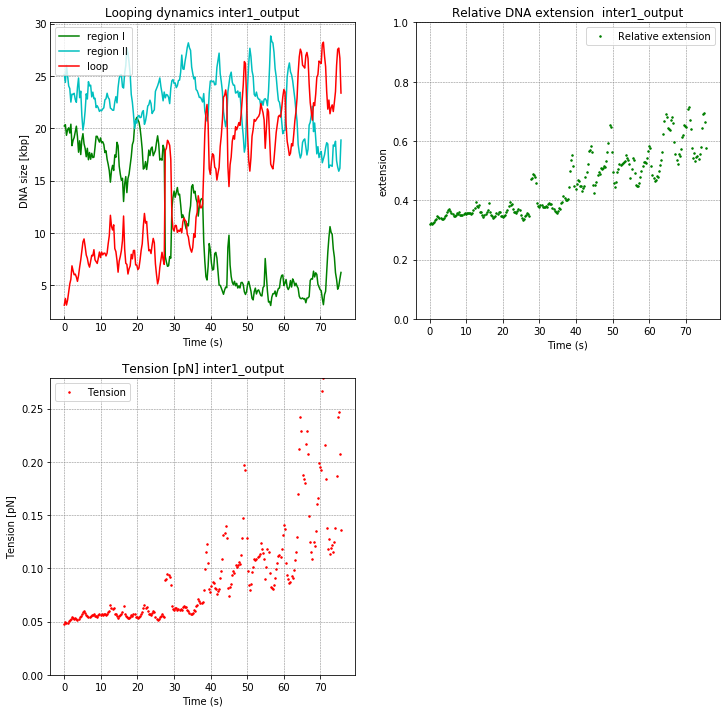

inter2_output
End-to-end distance: 11.76 kb
Final loop size: 17.58 kb
stall force:  0.06 pN


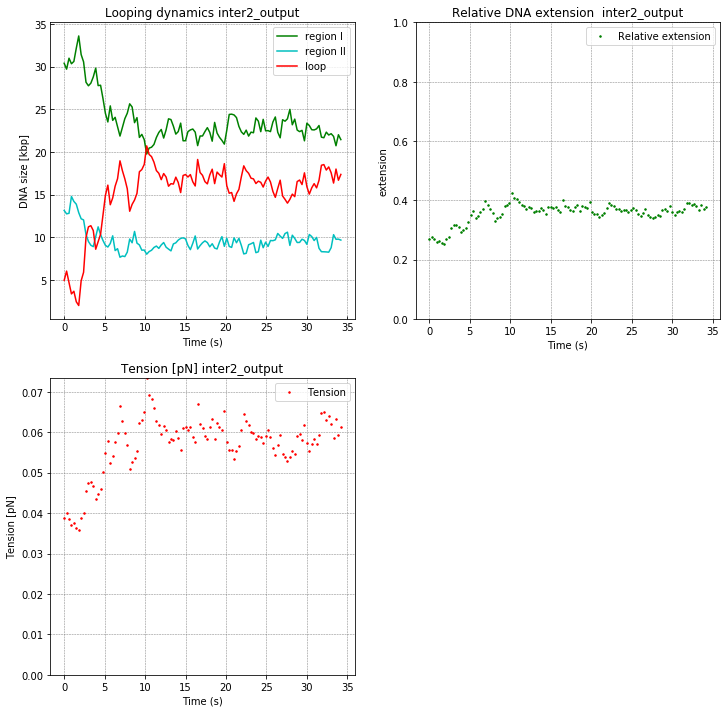

inter3_output
End-to-end distance: 11.89 kb
Final loop size: 22.25 kb
stall force:  0.08 pN


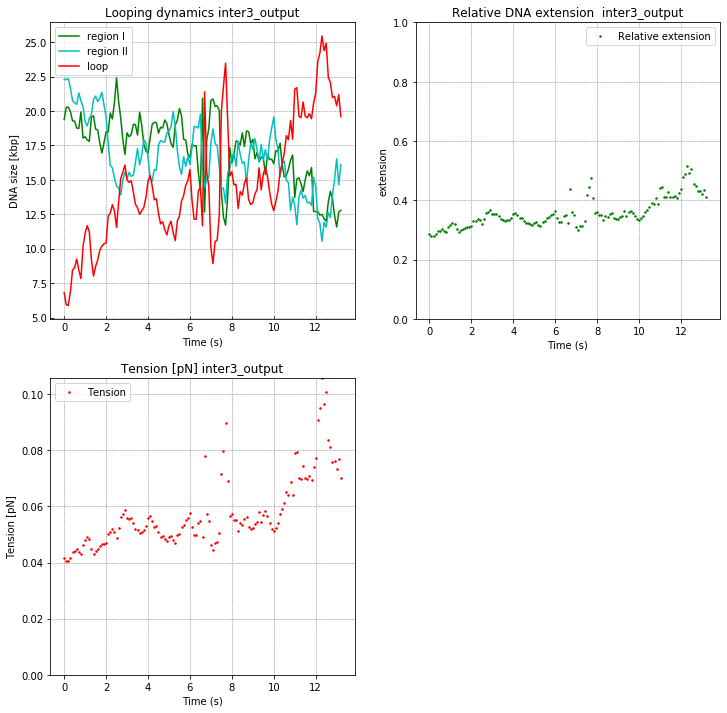

inter4_output
End-to-end distance: 9.88 kb
Final loop size: 19.61 kb
stall force:  0.05 pN


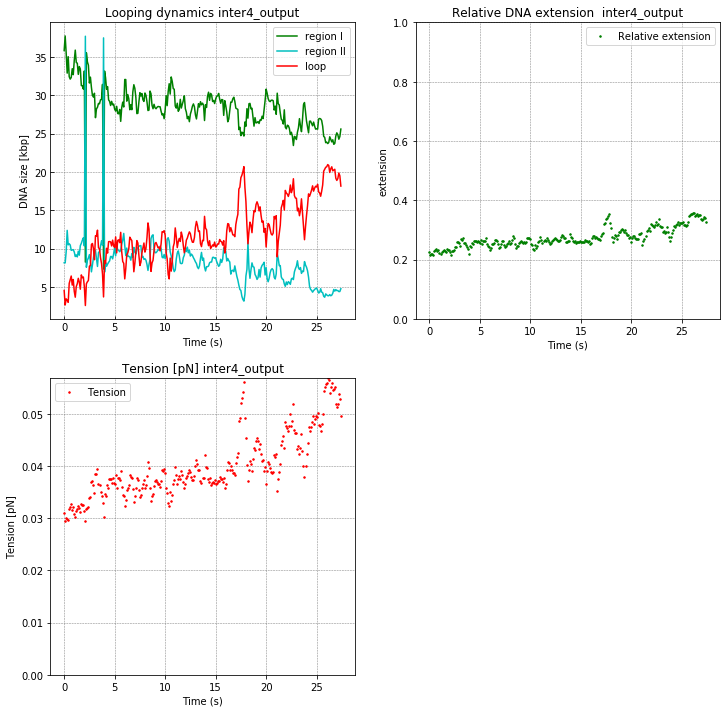

inter5_output
End-to-end distance: 10.59 kb
Final loop size: 30.94 kb
stall force:  0.18 pN


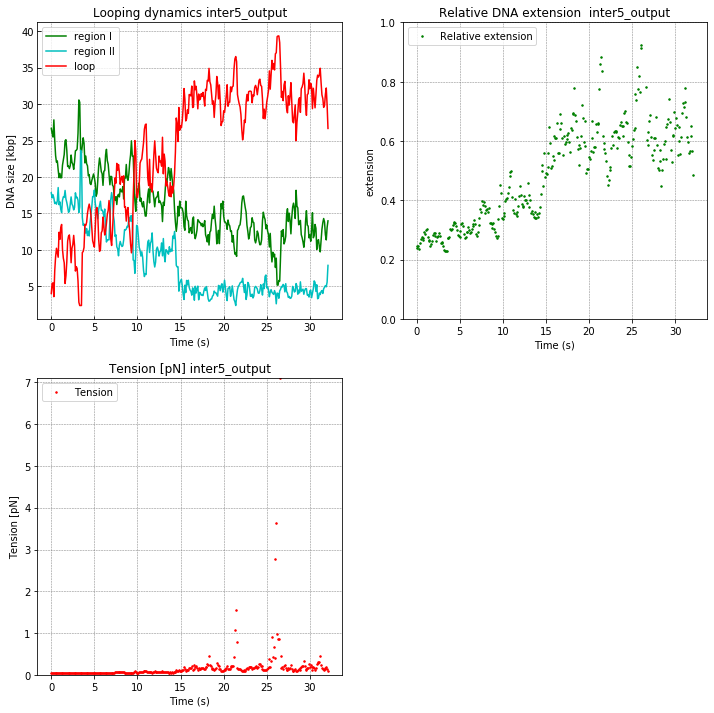

inter6_output
End-to-end distance: 5.27 kb
Final loop size: 35.21 kb
stall force:  0.07 pN


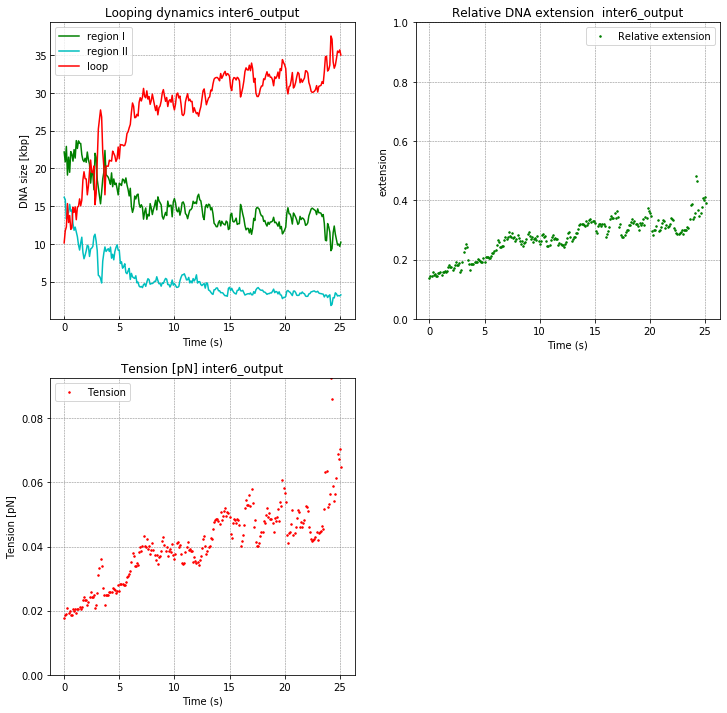

inter7_output
End-to-end distance: 4.84 kb
Final loop size: 36.32 kb
stall force:  0.07 pN


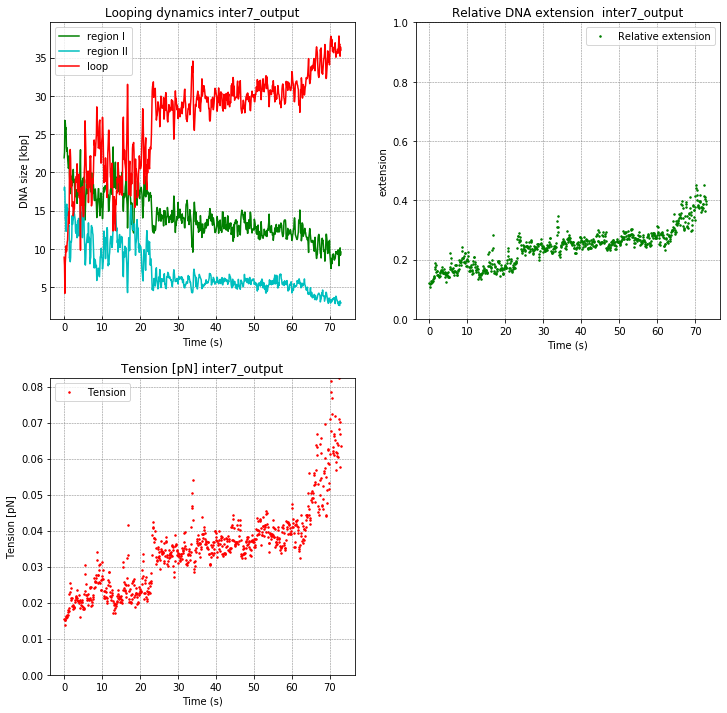

inter8_output
End-to-end distance: 16.39 kb
Final loop size: 16.06 kb
stall force:  0.1 pN


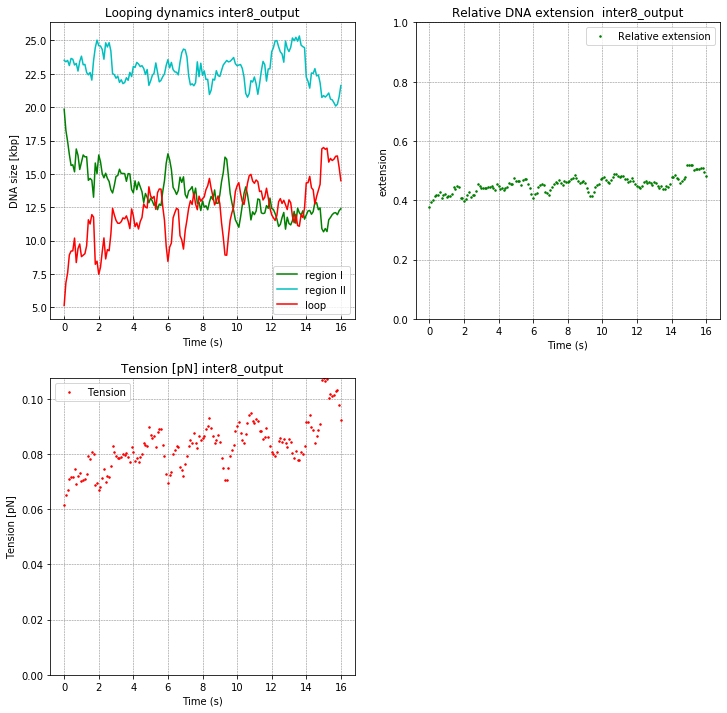

inter9_output
End-to-end distance: 15.23 kb
Final loop size: 16.16 kb
stall force:  0.09 pN


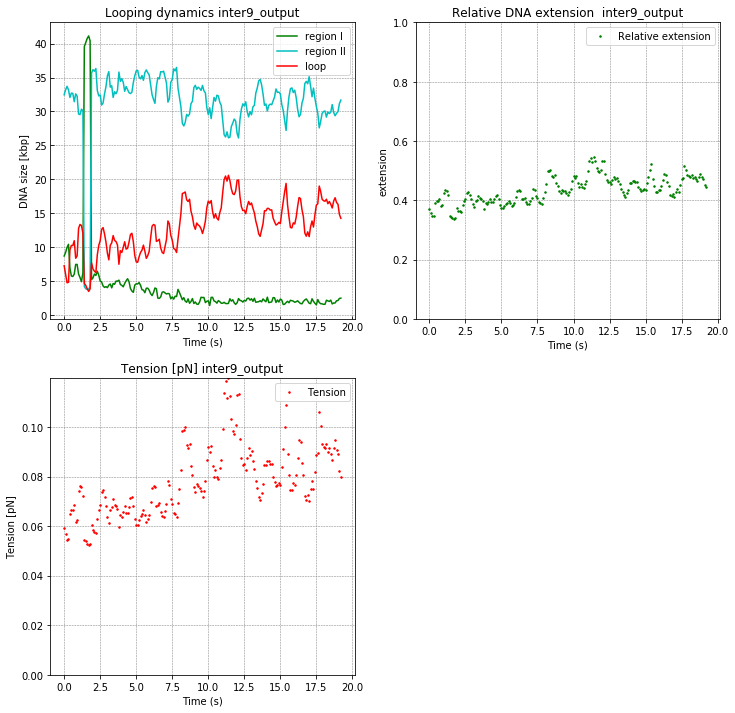

In [4]:
# define the force-extension relationship as in Marko 1995

def force(e):
    f = (1/4*(1-e)**(-2)-1/4+e)*1.380649e-23*293/51e-9
    return f

# define global arrays to store final stall force values & relative DNA extension
stalForces = []
DNA_RE = []
    
#initialize local arrays to store extension and tension values for each time-step
extension = []
tension = []
    
n = 0
##################################      reading in data     #########################################


# each *_output data file contains the following entries: 

# 0 - summed intensity in region I for each time point
# 1 - summed intensity in region II for each time point
# 2 - summed intensity in the loop for each time point
# 3 - initial relative extension of the DNA molecule in kb (dye-corrected)
# 4 - initial relative extension of the DNA molecule in um (dye-corrected)
# 5 - relative position of the maximum intensity for each time point
# 6 - start frame number of loop extrusion in original microscopy data
# 7 - end frame number of loop extrusion in original microscopy data
# 8 - time step between two subsequent frames
# 9 - pixel size in um
# 10 - dye corrected contour length of the DNA molecule
# 11 - symmetry score for the looping event


#loop over folder containing "filename_output"data files for each analysed strand & read data into array

for filename in os.listdir(path):
    data = []
    if filename.endswith("output"):
        print(filename)
        end = (filename.split(".",1)[0])
        with open(os.path.join(path,filename), 'rb') as r: 
            data = pickle.load(r)
    else: continue

    
# improve readability: assign data (size of one region for all time-steps) to new arrays 


    sum_I = data[0]
    sum_II = data[1]
    sum_lp = data[2]
    l_biobio = data[3]
    position = data[5]
    timestep = data[8]

        
    print('End-to-end distance:', np.round(l_biobio,2), 'kb')
    print('Final loop size:', np.round(np.average(sum_lp[-10::]),2), 'kb')
    
###############   quantify DNA extension and calculate tension  ###################

    sum_lp = np.array(sum_lp)
    
####    calculate the extension using total slack from DNA - DNA in loop & apply WLC model
    e = l_biobio/(48.5-sum_lp)
    f = force(e)

    extension.append(e)
    tension.append(f)

    
##########################   save the mean of the last 10 time-steps as the stall force    ##########################

    stal_force = np.mean(f[-10::])
    
    # check that the final extension values did not exeed 1 -> otherwise exclude 
    if all(e[-10::] < 0.98):
        stalForces.append(stal_force)
        print('stall force: ', np.round(stal_force*1e12,2), 'pN')
    else: 
        print('!!! Extension exceeds physical limit !!!')
        continue
    
##########    save extensions, forces, staling force & end-to-end-distance
    
#     relative_extension = l_biobio/48.5
#     DNA_RE.append(relative_extension)
    
#    outputs = [extension, tension, stal_force, l_biobio, relative_extension]
#    pickle.dump(outputs, open(out+'/'+end+'_FE', 'wb'))    

#     with open(out+'/'+end+'_FE.csv', 'w') as f: 
#         f.write('relative extension, tension [pN], initial extension'+ '\n')
#         writer = csv.writer(f, delimiter = ',')
#         writer.writerows(tuple(zip(extension, tension,)))


####################################   make final plots    ###############################
    
    t = np.arange(len(data[0]))*timestep
    
    plt.figure(figsize=(12,12))
    
    plt.subplot(221)
    plt.title('Looping dynamics '+filename)
    plt.plot(t,sum_I,'g-', label='region I')
    plt.plot(t,sum_II,'c-', label='region II')
    plt.plot(t,sum_lp, 'r-', label='loop')
    plt.grid(True, color = 'grey', linestyle='--', linewidth = 0.5)
    plt.tick_params(direction='in')
    plt.xlabel('Time (s)')
    plt.ylabel('DNA size [kbp]')
    plt.legend()
#    plt.savefig(out+'/'+ filename + '_dynamics.png')

    plt.subplot(222) 
    plt.title('Relative DNA extension  '+filename)
    plt.plot(t,extension[n], 'g.', ms = 3, label = 'Relative extension')
    plt.grid(True, color = 'grey', linestyle='--', linewidth = 0.5) 
    plt.ylim(0,1)
    plt.ylabel('extension')
    plt.xlabel('Time (s)')
    plt.legend()
#    plt.savefig(out+'/'+ filename + '_f-e.png')
    
    plt.subplot(223) 
    plt.title('Tension [pN] '+filename)
    plt.plot(t,tension[n]*1e12, 'r.', ms = 3, label = 'Tension')
    plt.grid(True, color = 'grey', linestyle='--', linewidth = 0.5)
    plt.ylim(0, np.max(tension[n])*1e12)
    plt.ylabel('Tension [pN]')
    plt.xlabel('Time (s)')
    plt.legend()
#    plt.savefig(out+'/'+ filename + '_f-e.png')
    plt.show()
    
    n+=1
    
# with open(out+'/'+'Force_Extension_all'+'.csv', 'w') as g: 
#     g.write('relative extension, stal w/o area under loop, stal force w area under loop'+ '\n')
#     writer = csv.writer(g, delimiter = ',')
#     writer.writerows(tuple(zip(DNA_extension, stalForces[0], stalForces[1])))
    
    

#final_outputs = [DNA_RE, stalForces]
#pickle.dump(final_outputs, open(out+'/stalForces_all', 'wb'))



## 2. Plot stall forces

Text(0.75, 5e-13, 'Mean stall force: 0.11 pN')

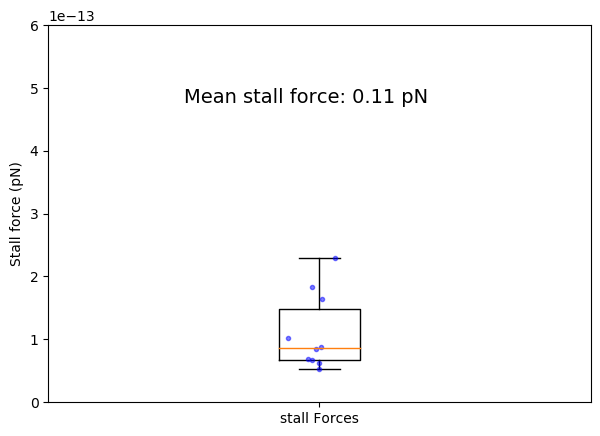

In [8]:
plt.figure(figsize = (7,5), dpi = 100)
plt.boxplot(stalForces, labels = ['stall Forces']) # Or you can use the boxplot from Pandas
y = stalForces
x = np.random.normal(1, 0.02, len(y))
plt.plot(x, y, 'b.', alpha=0.5)
plt.ylim(0,0.6e-12)
plt.ylabel('Stall force (pN)')
plt.text(0.75, 0.5*1e-12, 'Mean stall force: '+str(np.round(np.mean(stalForces)*1e12,2))+' pN', fontsize=14, verticalalignment='top')
# plt.savefig(out+'/Fstal.png')
# plt.savefig(out+'/Fstal.pdf')

## 3. Symmetry analysis

This script loops over the individual 'output' files for each looping event and calculates the symmetry score for the extrusion process by comparing the change in DNA size of the two regions outside of the loop.  

(Honestly the symmetry score is already saved in position 11 in each output file, because I calculate it right away when I analyse my microscopy files. But for the purpose of showing how we do it, lets calculate it again.)

inter10_output 0.22709712875733729
inter1_output 0.27364516994933985
inter2_output 0.28495198654282605
inter3_output 0.382190275342169
inter4_output 0.0940508799116493
inter5_output 0.03987640379597508
inter6_output 0.017562110879738132
inter7_output 0.08155170535334483
inter8_output 0.29226993444550925
inter9_output 0.38389250427483435


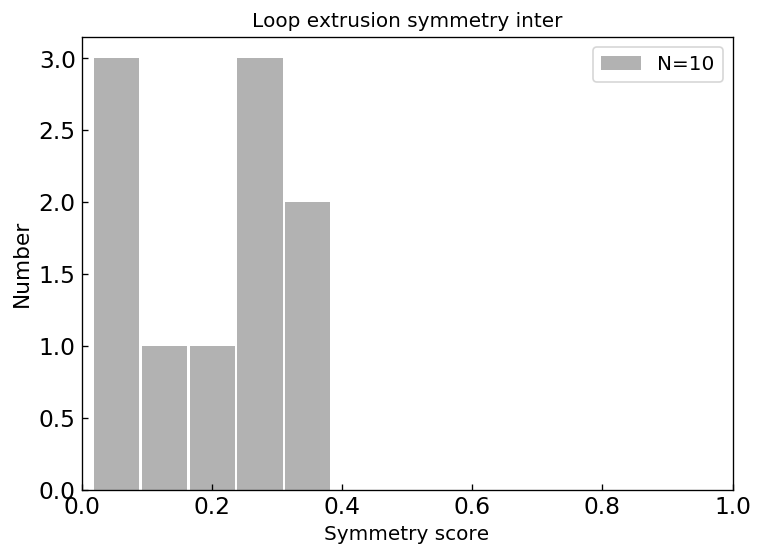

In [62]:
# define the funciton for scoring symmetry 

symmetry = []

def symmetry_score(regionI,regionII): 
    if regionI > 0: 
        regionI = 0
    else:     
        pass
    
    if regionII > 0:
        regionII = 0
    else: 
        pass

    s = -(min(regionI,regionII)-max(regionI,regionII))/(-regionI-regionII)
    return s


#################################      reading in data     #########################################

for filename in os.listdir(path):
    data = []
    if filename.endswith("output"):
        end = (filename.split(".",1)[0])
        with open(os.path.join(path,filename), 'rb') as r: 
            data = pickle.load(r)
    else: continue

    
# improve readability: assign data (size of one region for all time-steps) to new arrays 

    try: 
        sum_I = data[0]
        sum_II = data[1]
        sum_lp = data[2]
        l_biobio = data[3]
        timestep = data[8]
    except IndexError:
        sum_I = data[1]
        sum_II = data[2]
        sum_lp = data[3]
        l_biobio = data[4]

        
###############   quantify changes in DNA content in region I and II ###################

    dRegI = (np.average(sum_I[-10:-1]) - np.average(sum_I[0:10]))
    dRegII = (np.average(sum_II[-10:-1]) - np.average(sum_II[0:10]))

##  quantify symmetry
    
    sym = symmetry_score(dRegI,dRegII)
    symmetry.append(sym)
    
    print(filename, sym)
        
        
##########    save changes in region I, region II, initial relative extension and symmetry score


#     symmetry_outputs = [RE, regI, regII, symmetry]
#     pickle.dump(symmetry_outputs, open(path+'/'+filename.split('_',1)[0]+'_symmetry_output', 'wb'))

    # save final tension data to csv file

#     with open(path+'/'+filename.split('_',1)[0]+'_symmetry_output'+'.csv', 'w') as g: 
#         g.write('RE, delta region I, delta region II, symmetry'+ '\n')
#         writer = csv.writer(g, delimiter = ',')
#         writer.writerows(tuple(zip(RE, regI, regII, symmetry)))


####################################   make final plots    ###############################

plt.figure(figsize=(7,5), dpi= 120)
plt.title('Loop extrusion symmetry '+path.split("/",-1)[-1], fontsize = 12)
plt.hist(symmetry, histtype='bar', bins = 5,  rwidth=0.95, color='k', alpha = 0.3, label = 'N=' + str(len(symmetry)))
plt.tick_params(direction='in')
plt.xlim(0,1)
plt.xlabel('Symmetry score', fontsize=12)
plt.ylabel('Number', fontsize=13)
plt.legend(fontsize = 12)
plt.rcParams.update({'font.size': 14})
#     plt.savefig(out+'/'+filename.split('_',1)[0]+'_symmetries.pdf')
#     plt.savefig(out+'/'+filename.split('_',1)[0]+'_symmetries.png')
plt.show()
    


## 4. Initial extrusion rates

To estimate loop extrusion rates, we fit an exponential function to the loop data and extract the initial extrusion rate from the first derivative of the fit function at time point 0. <br>
Other methods, such as fitting a linear slope to the first 15 time points have proven less stable in cases of noisy data. 

inter10_output inter10
[39.0445728  31.01160046 -0.09257421] [1.74621493 1.45364748 0.01148938]


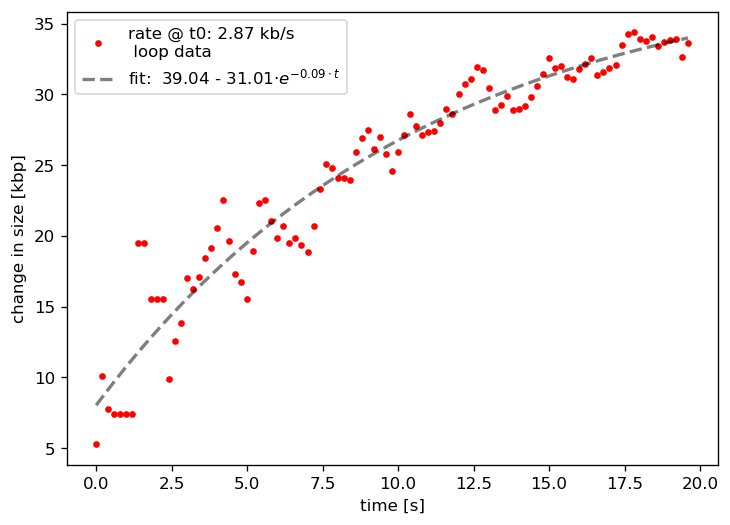

inter1_output inter1
Error - gaussian curve_fit failed, right side, in run <built-in method f of mtrand.RandomState object at 0x113289678>
inter2_output inter2
[16.90781366 16.25731729 -0.29270062] [0.21332082 0.96828158 0.0296453 ]


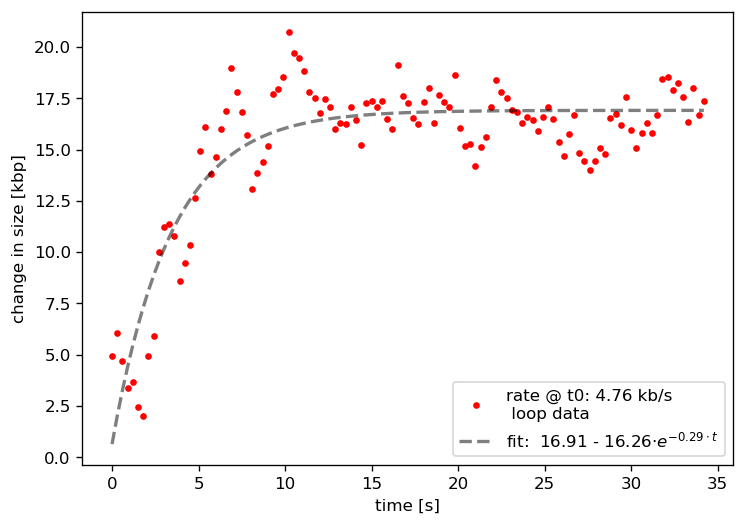

inter3_output inter3
Error - gaussian curve_fit failed, right side, in run <built-in method f of mtrand.RandomState object at 0x113289678>
inter4_output inter4
Error - gaussian curve_fit failed, right side, in run <built-in method f of mtrand.RandomState object at 0x113289678>
inter5_output inter5
[37.55559477 33.57529855 -0.06883218] [1.21572838 1.01111312 0.00632746]


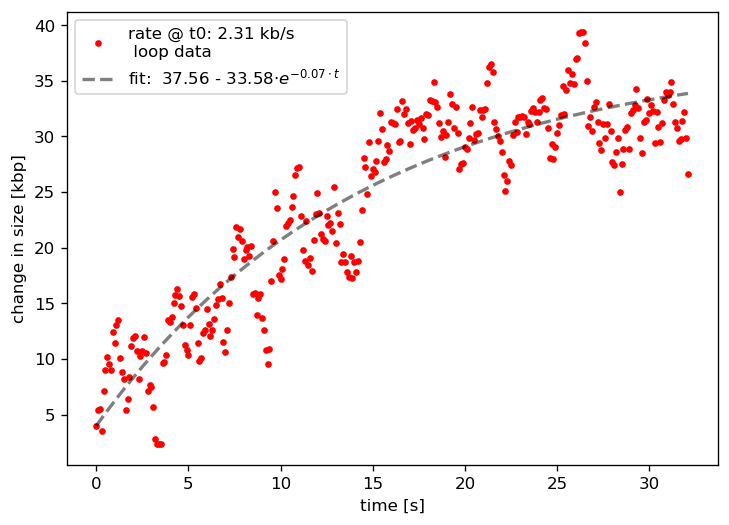

inter6_output inter6
[32.786151   21.43125617 -0.1793875 ] [0.2405229  0.46593868 0.00908107]


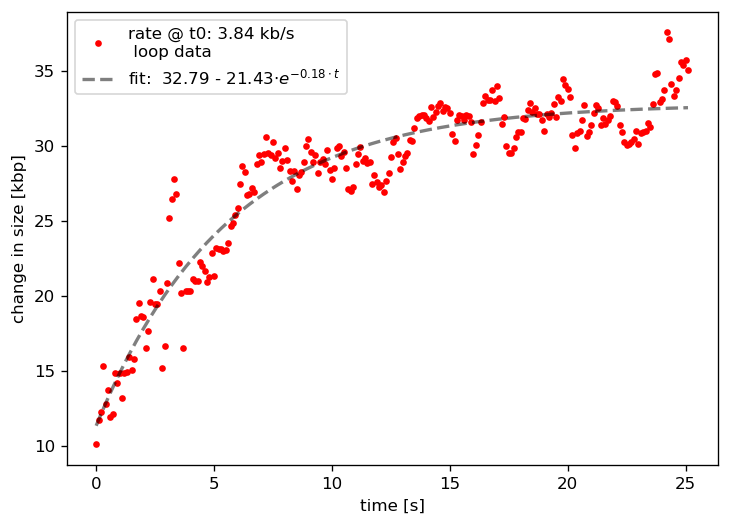

inter7_output inter7
[ 3.65955990e+01  2.18550359e+01 -2.75976806e-02] [0.74320235 0.60970041 0.00222593]


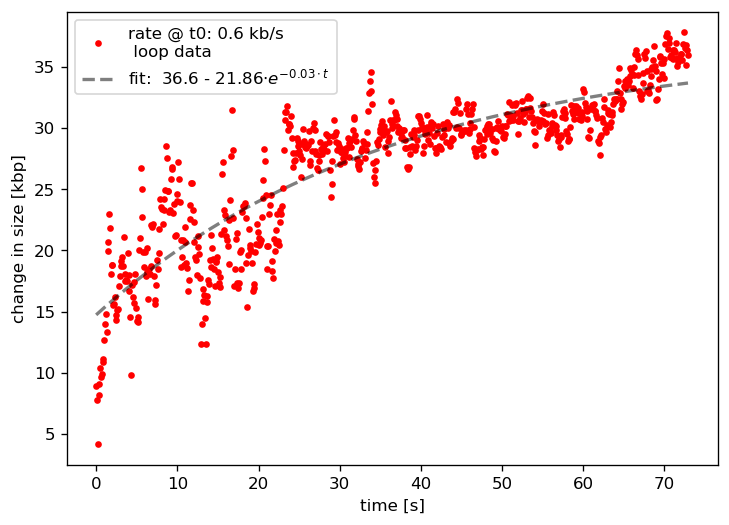

inter8_output inter8
[15.13145276  6.55963652 -0.11829464] [0.95358724 0.78773146 0.03906556]


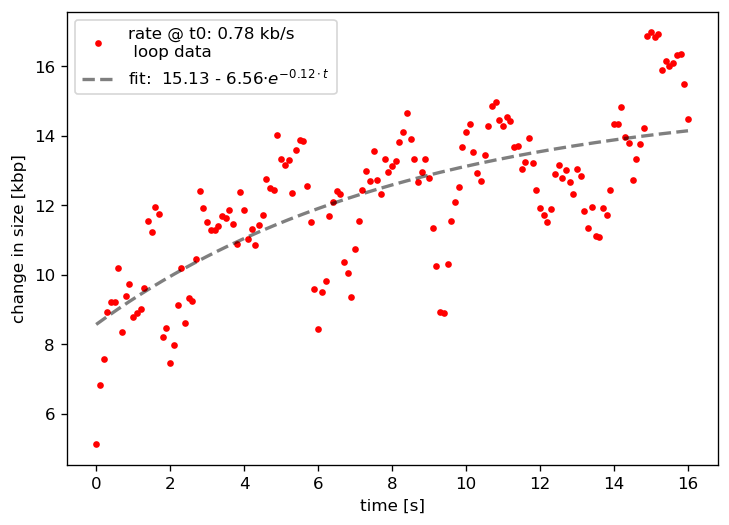

inter9_output inter9
[17.48295298 10.91028757 -0.11709611] [1.0629369  0.89046409 0.02932221]


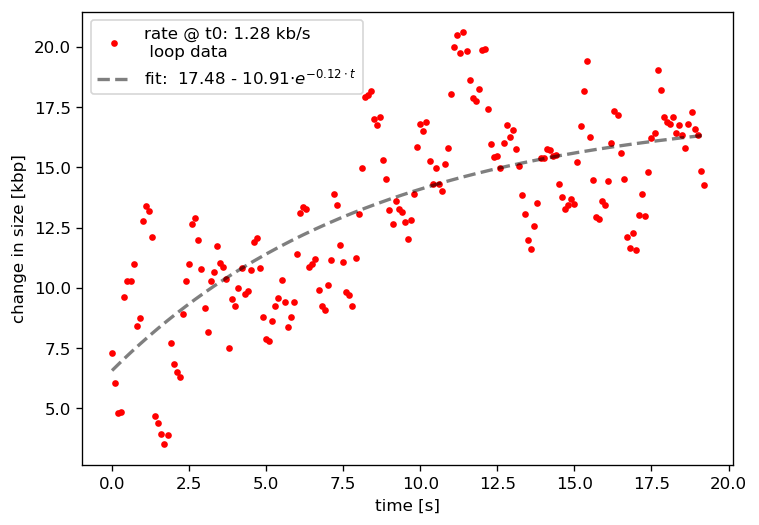

In [15]:
from pylab import *
import scipy
from scipy.optimize import curve_fit

# get looping data from favorite files with 0 - I, 1 - II, 2 - loop, 3 - l_biobio in kbp 

fit_outputs = []
relative_extension = []

RE = []

fit_a = []
fit_b = []
fit_k = []

err_a = []
err_b = []
err_k = []

rate = []

for filename in os.listdir(path):
    data = []
    if filename.endswith("output"):
        end = (filename.split("_output")[0])
        print(filename,end)
        with open(os.path.join(path,filename), 'rb') as r: 
            data = pickle.load(r)
    else: 
        continue
            
    
###################       reading in metadata       #########################

    timestep = data[8]
    px_size = data[9]
    cl = data[10]
    RE.append(data[3]/48.5)
        
###############             define exponential fit function         ####################################
    
    def exponential(t, a, b, k):
        return a - b*np.exp(k*t)

    # get x values by making array with number loop values * timestep

    t = np.arange(len(data[0]))*timestep

    try: 
        popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, t, data[2], p0=[1,1,-0.1])
        perr_exponential = np.sqrt(np.diag(pcov_exponential))
        print(popt_exponential, perr_exponential)

        
        r = popt_exponential[1]*popt_exponential[2]*(-1)
        rate.append(r)
        
        plt.figure(figsize=(7,5), dpi= 120)
        plt.plot(t, data[2], 'ro', ms = 3, label = 'rate @ t0: %s kb/s \n loop data'%(str(round(r, 2))))
        plt.plot(t, exponential(t,popt_exponential[0], popt_exponential[1], popt_exponential[2]), 'k--', linewidth = 2, alpha = 0.5, label = 'fit:  ' + str(round(popt_exponential[0],2)) + ' - ' + str(round(popt_exponential[1],2)) + '$\cdot e^{%s \cdot t}$' %(str(round(popt_exponential[2],2))))
        plt.ylabel('change in size [kbp]')
        plt.xlabel('time [s]')
        plt.legend()
#         plt.savefig(out+'/' + filename.split('_',1)[0] + '_loop_fit.png')
        plt.show()

        #calculate relative extension
        rel_ext = data[3]/48.5

        # write DNA extension, parameters & errors to array & save as python pickle

        relative_extension.append(rel_ext)
        
        fit_a.append(popt_exponential[0])
        fit_b.append(popt_exponential[1])
        fit_k.append(popt_exponential[2])

        err_a.append(perr_exponential[0])
        err_b.append(perr_exponential[1])
        err_k.append(perr_exponential[2])
        
    except RuntimeError:  # if n = 800 rounds of fitting are not enough to get a good fit
            print("Error - gaussian curve_fit failed, right side, in run {0}".format(f))
            # pass
            continue
    
# fit_outputs = [relative_extension, rate, fit_a, fit_b, fit_k, err_a, err_b, err_k]
# pickle.dump(fit_outputs, open(out+'/inter_loop_fit_output', 'wb'))

# with open(out+'/'+'inter_extrusion_rates'+'.csv', 'w') as g: 
#     g.write('relative_extension, rate [kb/s], fit_a, fit_b, fit_k, err_a, err_b, err_k'+ '\n')
#     writer = csv.writer(g, delimiter = ',')
#     writer.writerows(tuple(zip(relative_extension, rate, fit_a, fit_b, fit_k, err_a, err_b, err_k)))




In [14]:
len(rate)

7

## 5. Loop movement

Last, we analyse the movement of the loop along the DNA strand during loop extrusion. The '*_output' data files contain the loop position for every time point relative to the length of the DNA molecule. This bloc plots the movement of each loop along the DNA strand and analyses the loop displacement from the starting and end position of the loop. 

inter10_output inter10


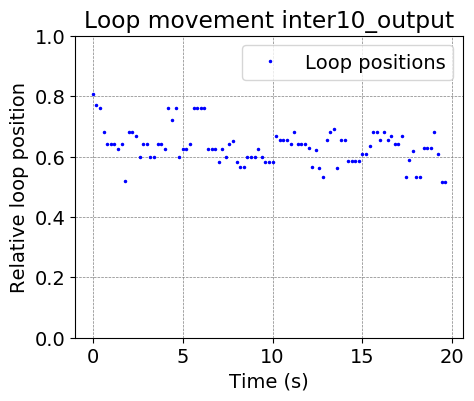

stationary 0.07547402778775325
inter1_output inter1


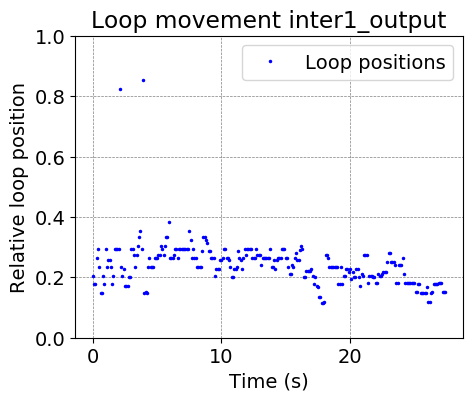

stationary -0.030233709645474338
inter2_output inter2


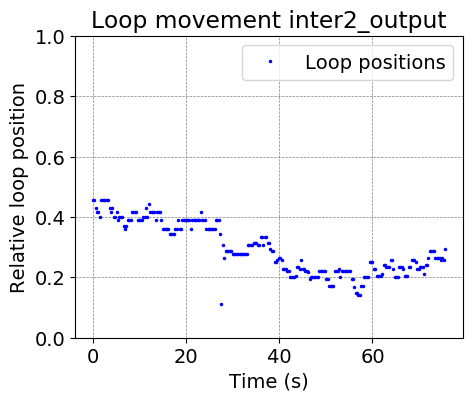

boundary mover -0.17278244631185813 

inter3_output inter3


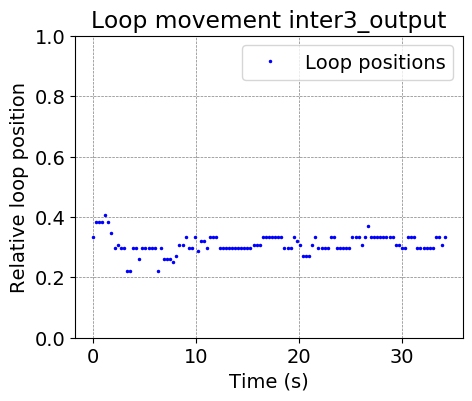

stationary -0.04677113010446349
inter4_output inter4


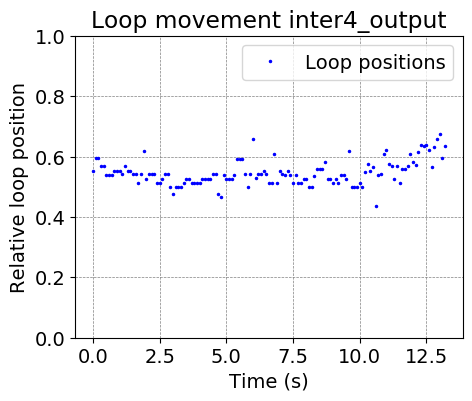

stationary -0.06883046536064397
inter5_output inter5


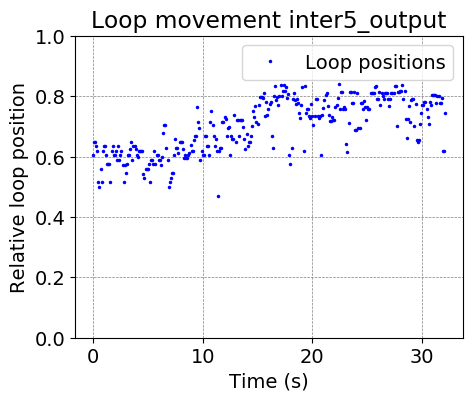

boundary mover -0.16615108044089388 

inter6_output inter6


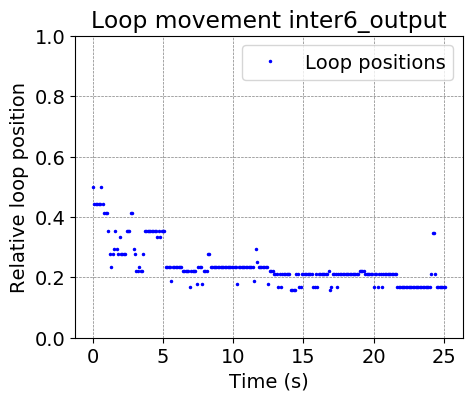

boundary mover -0.23722199787619092 

inter7_output inter7


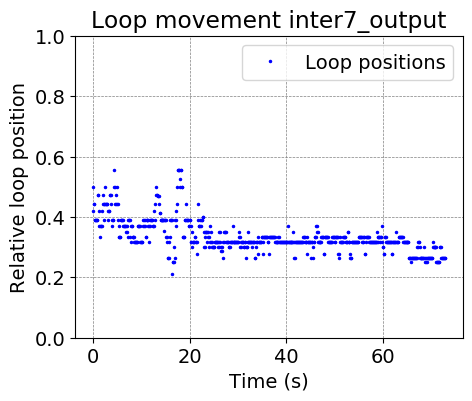

boundary mover -0.14707602339181286 

inter8_output inter8


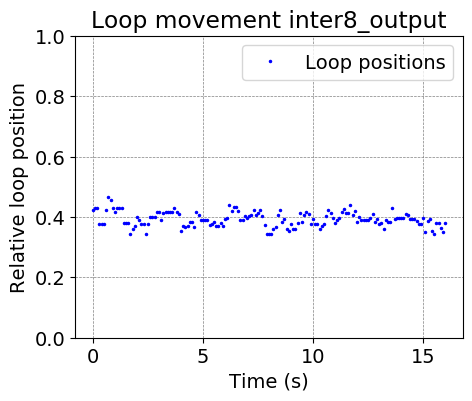

stationary -0.05222027749958025
inter9_output inter9


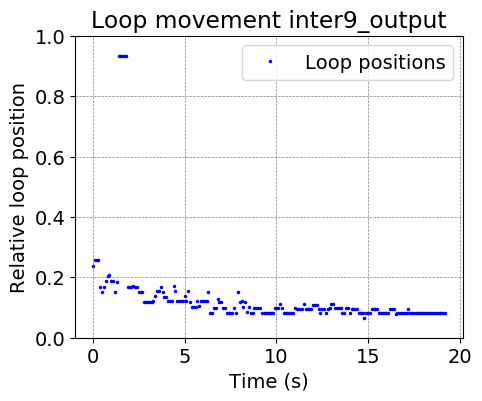

boundary mover -0.12876063432250864 

0.0


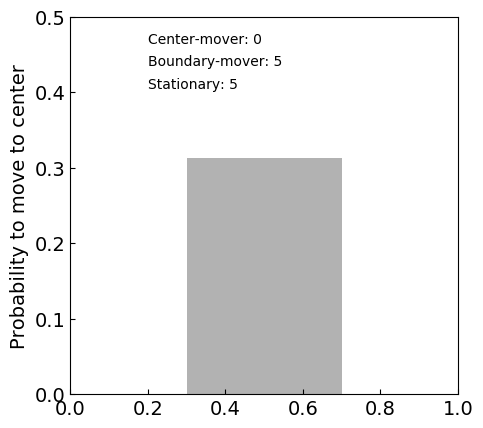

In [64]:
movement = []
new = []
center = []
boundary = []
RE = []

for filename in os.listdir(path):
    data = []
    if filename.endswith("output"):
        end = (filename.split("_output")[0])
        print(filename,end)
        with open(os.path.join(path,filename), 'rb') as r: 
            data = pickle.load(r)
    else: 
        continue
        
###########    reading in data   ###############
    
    RE.append(data[3])
    timestep = data[8]
    peak_position = data[5]

    t = np.arange(len(data[0]))*timestep
    
    plt.figure(figsize = (5,4), dpi = 100)
    plt.title('Loop movement '+filename)
    plt.plot(t,peak_position, 'b.', ms = 3, label = 'Loop positions')
    plt.grid(True, color = 'grey', linestyle='--', linewidth = 0.5)
    plt.ylim(0,1)
    plt.ylabel('Relative loop position')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.show()
    
#######################     now analyse loop displacement   #####################################

    init_pos = np.mean(peak_position[0:10])
    
# depending on where loop starts make decision how to calculate change in position d_pos 
# d_pos quantifies the change in loop position and is always positive for center mover & negative for boundary movement
# if loop starts very close to center, the decision can be flawed -> if distance btw. center 0.5 and initial
# position is very small, loop starts at center and always moves to boundary = boundary mover -> d_pos :< 0 

    if init_pos-0.5 >= 0.04:
        d_pos = np.mean(peak_position[0:10]) - np.mean(peak_position[-10:-1])
    elif init_pos-0.5 <= -0.04: 
        d_pos = np.mean(peak_position[-10:-1]) - np.mean(peak_position[0:10])
    else: 
        d_pos = (-1)*np.abs(np.mean(peak_position[-10:-1]) - np.mean(peak_position[0:10]))

    if d_pos > 0 and np.abs(d_pos) > 0.08: 
        print('center mover', d_pos , '\n')
    elif d_pos < 0 and np.abs(d_pos) > 0.08: 
        print('boundary mover', d_pos, '\n')
    else: 
        print('stationary', d_pos)

    movement.append(d_pos)


#################      now analyse loop displacement with respect to DNA center and nearest boundary


for n in movement: 
    if np.abs(n) > 0.1:
        new.append(n)
    else: 
        continue
        

for n in new:
    if n > 0: 
        center.append(n)
    else: 
        boundary.append(n)

z = len(center)/(len(RE))
print(z)

y = [0.3125,z]

plt.figure(figsize=(5,5), dpi = 100)
plt.bar(0.5,y, width = 0.4, color = 'k', alpha = 0.3)
plt.xlim(0, 1)
plt.ylim(0,0.5)
plt.tick_params(direction='in')
plt.ylabel('Probability to move to center')
plt.text(0.2, 0.48, 'Center-mover: '+str(len(center)) , fontsize=10, verticalalignment='top')
plt.text(0.2, 0.45, 'Boundary-mover: '+str(len(boundary)) , fontsize=10, verticalalignment='top')
plt.text(0.2, 0.42, 'Stationary: '+str(len(RE)-len(center)-len(boundary)) , fontsize=10, verticalalignment='top')

plt.show()

        